In [1]:
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer


Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 6), reused 18 (delta 4), pack-reused 0
Unpacking objects: 100% (49/49), 1.86 MiB | 2.39 MiB/s, done.


In [2]:
!pip install -qr vision_transformer/vit_jax/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.5/390.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install jaxlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 9.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.10+cuda11.cudnn86
    Uninstalling jaxlib-0.4.10+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.10+cuda11.cudnn86


In [ ]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2
from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [ ]:
import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt

pd.options.display.max_colwidth = None
logging.set_verbosity(logging.INFO)  # Shows logs during training.

In [ ]:
# Create a new temporary workdir.
workdir = f'./workdirs/{int(time.time())}'
workdir

'./workdirs/1687537976'

In [ ]:
workdir

'./workdirs/1687423517'

In [ ]:
config = augreg_config.get_config('S_16')
config.dataset = 'drive/MyDrive/AutismFaceData'
config.batch_eval = 300

# Some more parameters that you will often want to set manually.
# For example for VTAB we used steps={500, 2500} and lr={.001, .003, .01, .03}
config.base_lr = 0.01
# config.shuffle_buffer = 1000 #default value is 50_000
config.total_steps = 100
config.warmup_steps = 10
# config.accum_steps = 0  # Not needed with R+Ti/16 model.
config.pp['crop'] = 224

In [ ]:
# And fine-tune on images provided
opt = train.train_and_evaluate(config, workdir)

INFO:absl:Reading dataset from directories "drive/MyDrive/AutismFaceData/train" and "drive/MyDrive/AutismFaceData/test"
INFO:absl:<_PrefetchDataset element_spec={'image': TensorSpec(shape=(1, 512, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(1, 512, 2), dtype=tf.float32, name=None)}>
INFO:absl:<_PrefetchDataset element_spec={'image': TensorSpec(shape=(1, 300, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(1, 300, 2), dtype=tf.float32, name=None)}>
INFO:absl:Selected fillename="S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0" for "S_16" with final_val=0.472
INFO:absl:Found no checkpoint files in workdirs/1687636118 with prefix checkpoint_
INFO:absl:Will start/continue training at initial_step=1
INFO:absl:[Hyperparameters] {'accum_steps': 8, 'base_lr': 0.01, 'batch': 512, 'batch_eval': 300, 'checkpoint_every': 1000, 'dataset': 'drive/MyDrive/AutismFaceData', 'decay_type': 'cosine', 'eval_every': 100, 'grad_norm_clip': 1.0, 'mode

In [ ]:
import flax
from flax.training import checkpoints as flax_checkpoints
from vit_jax import input_pipeline
dataset_info = input_pipeline.get_dataset_info(config.dataset, 'train')
_, ds_test = input_pipeline.get_datasets(config)
model_config = models_config.AUGREG_CONFIGS['S_16']
cp_path = "./workdirs/1687423517/checkpoint_100"

INFO:absl:Reading dataset from directories "drive/MyDrive/AutismFaceData/train" and "drive/MyDrive/AutismFaceData/test"


In [ ]:
import jax
import jax.numpy as jnp
# Get model instance - no weights are initialized yet.
model = models.VisionTransformer(
    num_classes=dataset_info['num_classes'], **model_config)


In [ ]:
# Get a single example from dataset for inference.
batch = next(iter(ds_test))

In [ ]:
def init_model():
    return model.init(
        jax.random.PRNGKey(0),
        # Discard the "num_local_devices" dimension for initialization.
        jnp.ones(batch['image'].shape[1:], batch['image'].dtype.name),
        train=False)


In [ ]:
import optax
from vit_jax import utils
# Load a checkpoint ...
variables = jax.jit(init_model, backend='cpu')()
params=variables['params']
lr_fn = utils.create_learning_rate_schedule(100, config.base_lr,
                                              config.decay_type,
                                              config.warmup_steps)
tx = optax.chain(
    optax.clip_by_global_norm(config.grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
opt_state = tx.init(params)
initial_step = 1
params, opt_state, initial_step = flax_checkpoints.restore_checkpoint(
      cp_path, (params, opt_state, initial_step))


INFO:absl:Restoring legacy Flax checkpoint from workdirs/1687423517/checkpoint_100


In [ ]:
def pp(img, sz):
  """Simple image preprocessing."""
  img = tf.cast(img, float)
  img = tf.image.resize(img, [sz, sz])
  return img
resolution = 128


In [ ]:
def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

In [ ]:
import numpy as np
correct_num = 0
total_num = 0
images = batch['image'][0]
labels = batch['label'][0]
mis_images = []
mis_labeled = []
for i in range(images.shape[0]):
  img = images[i]
  label = labels[i]
  total_num += 1
  logits, = model.apply({'params': params}, pp(img, 224).numpy()[None], train=False)
  predict_label = np.argmax(np.exp(logits) / np.sum(np.exp(logits)))

  if predict_label == np.argmax(label):
    correct_num += 1
  else:
    mis_images.append(img)
    mis_labeled.append('autistic' if np.argmax(label) == 0 else 'non-autistic')

print(correct_num)
print(total_num)
show_img_grid(mis_images, mis_labeled)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Inference on batch with single example.
logits, = model.apply({'params': params}, pp(batch['image'][0][0], 250).numpy()[None], train=False)

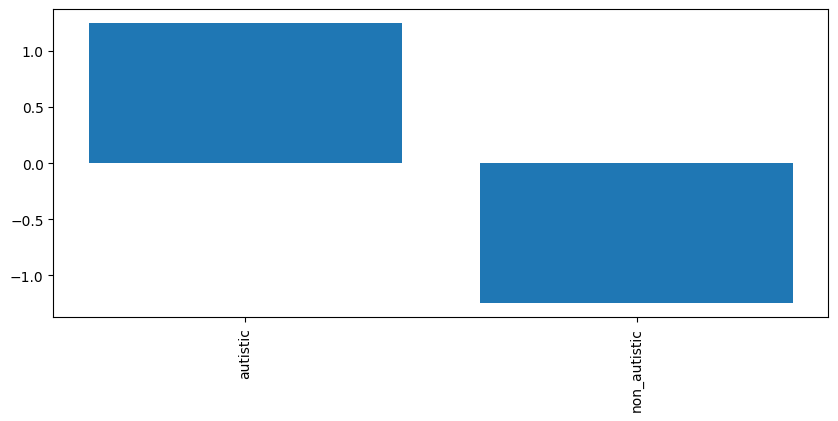

In [ ]:
# Plot logits (you can use tf.nn.softmax() to show probabilities instead).
plt.figure(figsize=(10, 4))
plt.bar(list(map(dataset_info['int2str'], range(len(logits)))), logits)
plt.xticks(rotation=90);